# **Exploration of Correlation Methods**

In [4]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore",message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")

import xarray as xr
import numpy as np
import scipy.signal as signal
import math
import pickle as pkl

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

import cmocean.cm as cm

import esmtools.stats as esmstats

In [14]:
## set up rcParams for plotting
mpl.rcParams['figure.dpi']= 120

In [138]:
def open_metric(var, reg, metric, timescale='monthly', ens_type=''):
    
    writedir = '/home/bbuchovecky/storage/so_predict_derived/'
    
    if metric == 'anom' or metric == 'mean':
        subdir = 'CTRL/'+var.upper()+'/'
        filename = var.lower()+'_ts_'+reg+'_'+timescale+'_'+metric+'.nc'
    
    if metric == 'ppp':
        subdir = 'PPP/'+var.upper()+'/'
        if ens_type != '':
            ens_type += '_'
        filename = var.lower()+'_ts_'+reg+'_'+timescale+'_'+ens_type+'ppp.nc'
        
    return xr.open_dataset(writedir+subdir+filename)

# Python Correlation Functions

**Documentation:**
* [numpy.correlate](https://numpy.org/doc/stable/reference/generated/numpy.correlate.html)
* [scipy.signal.correlate](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.signal.correlate.html#scipy.signal.correlate)
* [scipy.signal.correlation_lags](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.signal.correlation_lags.html#scipy.signal.correlation_lags)
* [matplotlib.pyplot.xcorr](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xcorr.html)
* **[esmtools.stats.corr](https://esmtools.readthedocs.io/en/stable/api/esmtools.stats.corr.html)**

**Helpful Resources:**
* [Wikipedia - Cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Cross-correlation_of_stochastic_processes)
* [Wikipedia - Autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation)
* [Why are the results of R's ccf and SciPy's correlate different?](https://stats.stackexchange.com/questions/339782/why-are-the-results-of-rs-ccf-and-scipys-correlate-different/353408)
* [How do I get R's ccf in Python?](https://stackoverflow.com/questions/53959879/how-do-i-get-rs-ccf-in-python)
* [How to interpret the values returned by numpy.correlate and numpy.corrcoef?](https://stackoverflow.com/questions/13439718/how-to-interpret-the-values-returned-by-numpy-correlate-and-numpy-corrcoef)
* [**Oceanography Correlation Analysis**](https://currents.soest.hawaii.edu/ocn_data_analysis/_static/SEM_EDOF.html)
* [Penn State - Cross Correlation Functions and Lagged Regressions](https://online.stat.psu.edu/stat510/lesson/8/8.2)
* [Deterministic Skill Scores](https://metclim.ucd.ie/wp-content/uploads/2017/07/DeterministicSkillScore.pdf)
* [**Applied Time Series Analysis for Fisheries and Environmental Sciences**](https://atsa-es.github.io/atsa/lectures.html)
* [**Correlation within and among time series**](https://atsa-es.github.io/atsa-labs/sec-tslab-correlation-within-and-among-time-series.html) <-- best source

# Definitions
Sample cross-variance function:

> $g_k^{xy} = \frac{1}{n}\sum_{t=1}^{n-k} \left(y_t-\bar{y}\right) \left(x_{t+k}-\bar{x}\right)$

Sample cross-correlation function:

> $r_k^{xy} = \frac{g_k^{xy}}{\sqrt{\text{SD}_x\text{SD}_y}} = \frac{g_k^{xy}}{\sigma_x\sigma_y}$

# Testing `esmtools.stats.corr`
Notes:
* only works with DataArrays
* need to test with manual computation of cross-correlation

In [9]:
esmstats.corr?

Signature: esmstats.corr(x, y, dim='time', lead=0, return_p=False)
Docstring:
Computes the Pearson product-moment coefficient of linear correlation.

Args:
    x, y (xarray object): Time series being correlated.
    dim (str, optional): Dimension to calculate correlation over. Defaults to
        'time'.
    lead (int, optional): If lead > 0, ``x`` leads ``y`` by that many time steps.
        If lead < 0, ``x`` lags ``y`` by that many time steps. Defaults to 0.
    return_p (bool, optional). If True, return both the correlation coefficient
        and p value. Otherwise, just returns the correlation coefficient.

Returns:
    corrcoef (xarray object): Pearson correlation coefficient.
    pval (xarray object): p value, if ``return_p`` is True.
File:      ~/miniconda3/envs/hmei/lib/python3.9/site-packages/esmtools/stats.py
Type:      function


In [131]:
## generate a sine signal with specified frequency, amplitude, and x-axis/horizontal shift
def gensignal(freq, amp, shift, length=1, num=100):
    time=np.linspace(0,length,num)
    signal = amp * np.sin(2 * np.pi * freq * time + shift)
    xr_signal =  xr.DataArray(
                    data = signal,
                    dims = ['time'],
                    coords = dict(time=np.arange(0,length,length/num)),
                    attrs = dict(
                            frequency=freq,
                            amplitide=amp,
                            shift=shift))
    return xr_signal

Min corr coeff:    -1.0 @ lead =   0.0
Max corr coeff:  0.9975 @ lead = -0.49


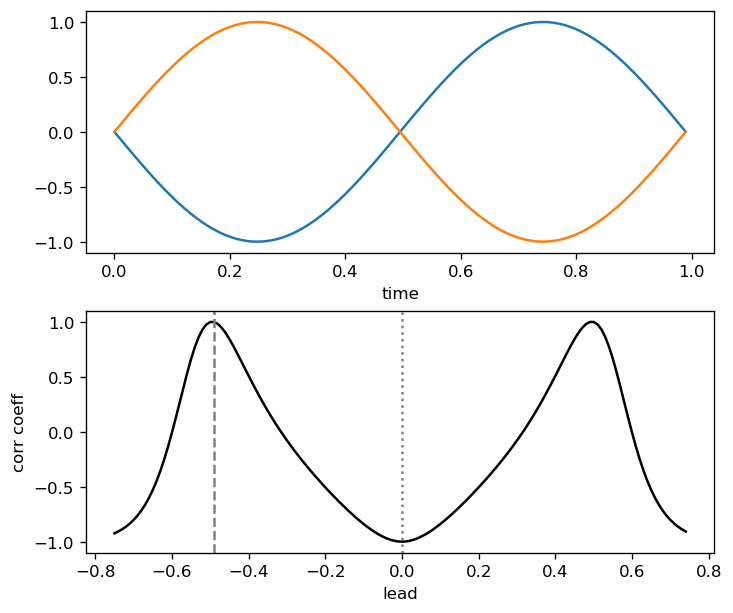

In [136]:
sig1 = gensignal(1, 1, np.pi)
sig2 = gensignal(1, 1, 0)

t = 150
leads = np.arange(-t/2, t/2, 1, dtype='int')
corrvals = np.zeros(t)

for (i, l) in zip(range(t), leads):
    corrvals[i] = esmstats.corr(sig1, sig2, dim='time', lead=l).values

fig,axes = plt.subplots(2, 1, figsize=(6,5), constrained_layout=True)

sig1.plot.line(ax=axes[0])
sig2.plot.line(ax=axes[0])

axes[1].plot(leads*0.01, corrvals, color='k')
axes[1].axvline(leads[np.argmin(corrvals)]*0.01, ls=':', color='gray')
axes[1].axvline(leads[np.argmax(corrvals)]*0.01, ls='--', color='gray')

axes[1].set_xlabel('lead')
axes[1].set_ylabel('corr coeff')

print(f'Min corr coeff: {np.min(corrvals):7.4} @ lead = {leads[np.argmin(corrvals)]*0.01:5.2}')
print(f'Max corr coeff: {np.max(corrvals):7.4} @ lead = {leads[np.argmax(corrvals)]*0.01:5.2}')

Abs max corr coeff:  0.577 @ lead = 13

Min corr coeff: -0.577 @ lead = 13
Max corr coeff:  0.176 @ lead = -191


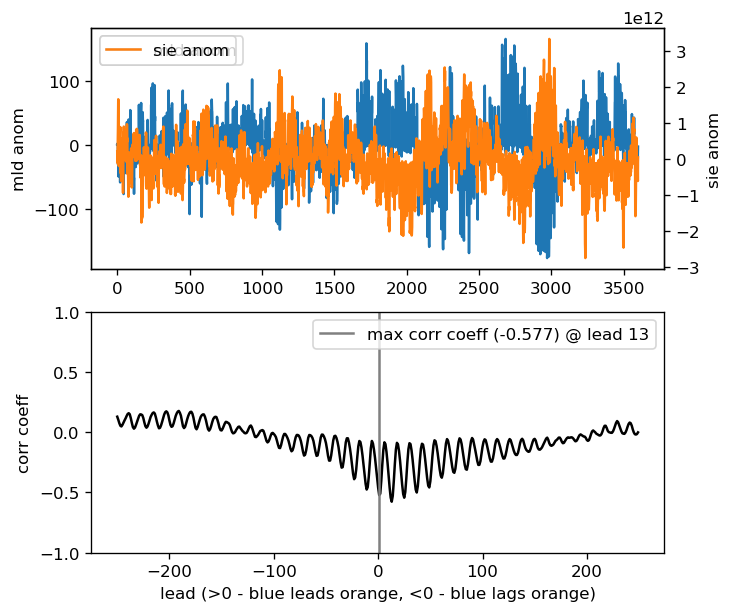

In [221]:
sig1 = open_metric('mld', 'so', 'anom').SouthernOcean
sig2 = open_metric('sie', 'so', 'anom').SouthernOcean

num_leads = 250
leads = np.arange(-num_leads, num_leads, 1, dtype='int')
corrvals = np.zeros(num_leads*2)

for (i, l) in zip(range(num_leads*2), leads):
    corrvals[i] = esmstats.corr(sig1, sig2, dim='month', lead=l).values

fig,[ax1a,ax2] = plt.subplots(2, 1, figsize=(6,5), constrained_layout=True)
ax1b = ax1a.twinx()

## time indexing for anomaly data
end_month = None
ax1a.plot(sig1.sel(month=slice(1,end_month)), color='tab:blue', label='mld anom')
ax1b.plot(sig2.sel(month=slice(1,end_month)), color='tab:orange', label='sie anom')

# sig1.sel(month=slice(1,36)).plot.line(ax=ax1a, color='tab:blue')
# sig2.sel(month=slice(1,36)).plot.line(ax=ax1b, color='tab:orange')

## time indexing for mean data
# ax1a.plot(sig1.sel(time=slice('0001-01', '0004-01')), color='tab:blue')
# ax1b.plot(sig2.sel(time=slice('0001-01', '0004-01')), color='tab:orange')

ax1a.set_ylabel('mld anom')
ax1b.set_ylabel('sie anom')
ax1a.legend()
ax1b.legend()

ax2.plot(leads, corrvals, color='k')
ax2.set_ylim(-1, 1)
ax2.set_xlabel('lead (>0 - blue leads orange, <0 - blue lags orange)')
ax2.set_ylabel('corr coeff')

abs_max_corrcoeff = np.max(abs(corrvals))
max_corrcoeff = corrvals[np.argmax(abs(corrvals))]
ax2.axvline(abs_max_corrcoeff, color='gray', label=('max corr coeff (%.3f) @ lead %d' % (max_corrcoeff, leads[np.argmax(abs(corrvals))])))
ax2.legend()

print(f'Abs max corr coeff: {np.max(abs(corrvals)):6.3} @ lead = {leads[np.argmax(abs(corrvals))]:2}\n')
print(f'Min corr coeff: {np.min(corrvals):6.3} @ lead = {leads[np.argmin(corrvals)]:2}')
print(f'Max corr coeff: {np.max(corrvals):6.3} @ lead = {leads[np.argmax(corrvals)]:2}')

In [12]:
## returns cross correlation with lag relative to y1
## (i.e., y2 lags y1)
## lead represented by a negative lag

def xcorr(y1, y2, max_lag=None, start_month=1, direction=None, normed=True):
    assert len(y1) == len(y2), 'y1 and y2 dimensions are not equal'
    
    mode = 'full'
    method = 'auto'
    size = len(y1)
    
    ## account for shifted lag=0 month
    if start_month != 1:
        y1 = y1[(start_month-1):]
        
        y2 = y2[(start_month-1):]
    
    ## compute the matrices of cross-correlation and lags
    if not normed:
        lags = signal.correlation_lags(len(y1), len(y2), mode=mode)
        xcorr = signal.correlate(y1, y2, mode=mode, method=method)
    if normed:
        lags = signal.correlation_lags(len(y1), len(y2), mode=mode)
        
        ## normalize with the following:
        xcov = signal.correlate(y1 - np.mean(y1), y2 - np.mean(y2), mode=mode, method=method)   
        xcorr = xcov / (y1.std() * y2.std() * size)
    
    ## ensure max_lag is valid
    if max_lag != None:
        assert max_lag <= size, 'max_lag is greater than input dimension'
    if max_lag == None:
        max_lag = size
        
    lo = size - max_lag
    hi = size + (max_lag - 1)
    
    if direction == 'lead':
        hi = size
        
    if direction == 'lag':
        lo = size-1
    
    return xcorr[lo:hi], lags[lo:hi]

199


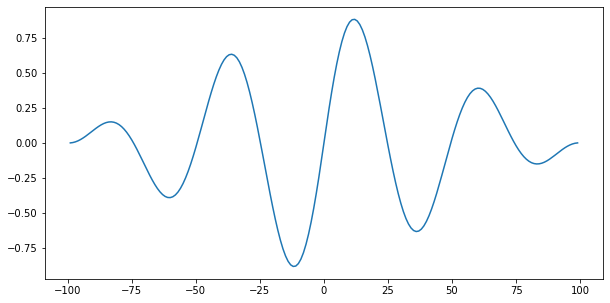

In [13]:
oscillations = 2
npts = oscillations * 50
y1 = np.sin(np.linspace(0,np.pi*2*oscillations,npts))
y2 = np.cos(np.linspace(0,np.pi*2*oscillations,npts))

xcorr_arr, lags_arr = xcorr(y1,y2,start_month=1)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(lags_arr, xcorr_arr)
print(xcorr_arr.size)

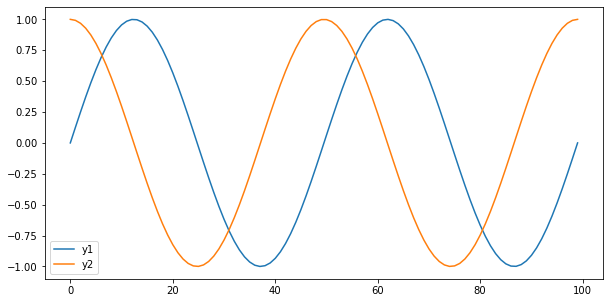

In [14]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(y1, label='y1')
ax.plot(y2, label='y2', color='tab:orange')
ax.legend()

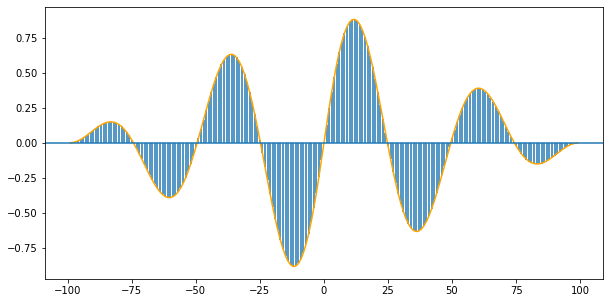

In [15]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(lags_arr, xcorr_arr, color='orange')

ax.xcorr(y1, y2, maxlags=len(y1)-1);

Slight difference between `plt.xcorr` and the normalized `signal.correlate`. I don't think it's a big deal, so I'm going to stick with the normalized `signal.correlate` because I have a better understanding of what exactly it is doing.

In [16]:
def xcorr_heatmap(
    target_var, other_vars, reg, metric, max_lag=12, normed=True, start_month=1, yaxis_steps=2, cmap=cmo.balance, figsize=(6,6)):

    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()

    reg_names = plotting_dicts['reg_names']
    var_su_names = plotting_dicts['var_su_names']
    var_lu_names = plotting_dicts['var_lu_names']
    var_ll_names = plotting_dicts['var_ll_names']
    abbrv_month_names = plotting_dicts['abbrv_month_names']
    abbrv_month_names = abbrv_month_names[(start_month-1):] + abbrv_month_names[:(start_month-1)]

    if reg.lower() == 'global':
        reg = 'Global'
        subreg = 'global'

    if reg.lower() != 'global' and reg.lower() != 'all':
        subreg = 'so'

    target_metric = open_metric(target_var, subreg, metric, timescale='monthly')
    xcorr_matrix = np.zeros((len(other_vars), 2*max_lag-1))
    var_names = []

    for (i,var) in zip(range(len(other_vars)), other_vars):
        other_metric = open_metric(var, subreg, metric, timescale='monthly')

        ## the target metric lags the other metric = the other metric leads the target metric
        xcorr_arr, lag_arr = xcorr(target_metric[reg].values, other_metric[reg].values, max_lag=max_lag, direction=None, normed=normed, start_month=start_month)

        xcorr_matrix[i] = xcorr_arr

        var_names.append(var_su_names[var])

    xcorr_matrix = xcorr_matrix.T

    ## plot
    fig,ax = plt.subplots(sharex=True, sharey=True, figsize=figsize)

    im = ax.pcolormesh(xcorr_matrix, vmin=-1, vmax=1, cmap=cmap, shading='auto')
    
    ax.set_xticks(np.arange(xcorr_matrix.shape[1]) + 0.5)
    ax.set_xticklabels(var_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    fig.suptitle(reg_names[reg]+' - XCORR - '+metric.upper())
    fig.tight_layout()

    cb = fig.colorbar(im, label='Correlation to NPP')
    
    return fig,ax

In [17]:
start_month=6
step = 2

file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
plotting_dicts = pkl.load(file)
file.close()

abbrv_month_names = plotting_dicts['abbrv_month_names']
abbrv_month_names = abbrv_month_names[start_month-1:] + abbrv_month_names[:start_month-1]
print('center = '+abbrv_month_names[0])

max_lag = 8
mult_factor = int(max_lag/12)+1

abbrv_month_names = abbrv_month_names * mult_factor
abbrv_month_names = abbrv_month_names[-max_lag+1:] + abbrv_month_names[:max_lag]
print('length = '+str(len(abbrv_month_names)))
print(abbrv_month_names)

size = len(abbrv_month_names)
print(abbrv_month_names[size // 2])
print(abbrv_month_names[0:size // 2:step] + abbrv_month_names[size // 2:size:step])

center = Jun
length = 15
['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan']
Jun
['Nov', 'Jan', 'Mar', 'May', 'Jun', 'Aug', 'Oct', 'Dec']


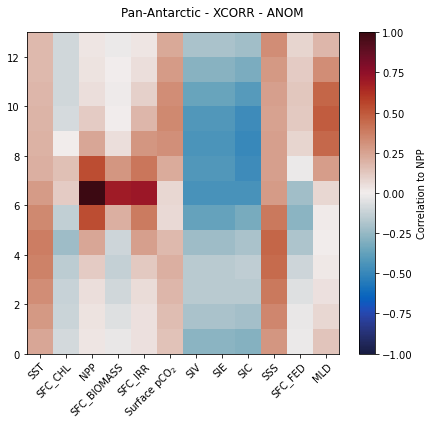

In [18]:
variables = ['sst', 'sfc_chl', 'npp', 'sfc_biomass', 'sfc_irr', 'pco2surf', 'siv', 'sie', 'cn_inv', 'sss', 'sfc_fed', 'mld']

target_var='npp'
other_vars=variables
reg='SouthernOcean'
metric='anom'

xcorr_heatmap(target_var, other_vars, reg, metric, max_lag=7, start_month=1, yaxis_steps=2);

# Simple Test

`x_l[target - lead]`

In [22]:
def cross_corr(x1, x2):
    product = np.mean((x1 - x1.mean()) * (x2 - x2.mean()))
    stds = x1.std() * x2.std()
    
    if stds == 0:
        return 0
    else:
        product /= stds
        return product
    
def select_month(x, imonth):
    return x[imonth:None:12]

## use slice notation to select one month across the 300 year control to correlate
def month_corr(x_t, x_l, target, lead):
    
    file = open('/home/bbuchovecky/storage/so_predict_derived/plotting_dicts.pkl','rb')
    plotting_dicts = pkl.load(file)
    file.close()
    
    print('target month = ', plotting_dicts['month_names'][target])
    print('lead month = ', plotting_dicts['month_names'][lead])

    print('length of \'x_t\' = ', len(x_t[target:None:12]))
    print('length of \'x_l\' = ', len(x_l[lead:None:12]))
    
    return cross_corr(select_month(x_t, target).values, select_month(x_l, lead).values)

month_corr(npp, sie, 0, 4)

target month =  January
lead month =  May
length of 'x_t' =  300
length of 'x_l' =  300


-0.2604762946997303

In [28]:
## y - response
## x - predictor

def cross_corr2(y, x, lead, target=0):
    
    print('length of y (response) = ', len(y[target:]))
    print('length of x (predictor) = ', len(x[lead:]))
    
    product = np.mean((y[target:] - y.mean()) * (x[target-lead:] - x.mean()))
    stds = y.std() * x.std()
    
    if stds == 0:
        return 0
    else:
        product /= stds
        return product
    
cross_corr2(npp, sie, lead=0, target=0).values

length of y (response) =  3600
length of x (predictor) =  3600


array(-0.44692867)

## `signal.correlate` and `np.correlate`

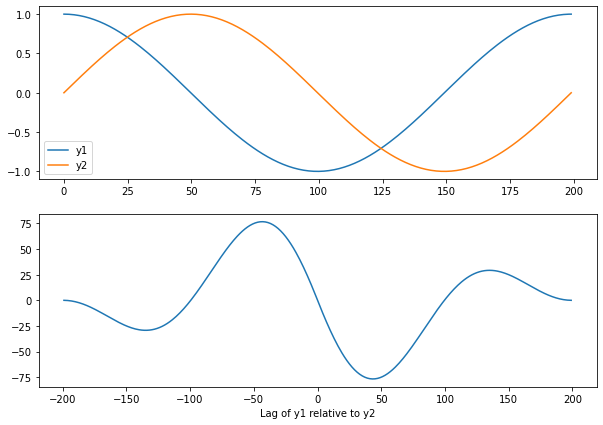

In [2]:
y1 = np.cos(np.linspace(0,np.pi*2,200))
y2 = np.sin(np.linspace(0,np.pi*2,200))

mode = 'full'
signal_corr = signal.correlate(y1, y2, mode=mode)
signal_lags = signal.correlation_lags(y1.size, y2.size, mode=mode)

fig, (ax_signals, ax_corr) = plt.subplots(2, 1, figsize=(10,7))

ax_signals.plot(y1, label='y1')
ax_signals.plot(y2, label='y2')
ax_signals.legend()

ax_corr.plot(signal_lags, signal_corr)

xlim = ax_corr.get_xlim()

ax_corr.set_xlabel('Lag of y1 relative to y2');

In the plot above, `y1` leads `y2` (alternatively `y2` lags `y1`) which is shown by the peak in correlation at around lag = 50.

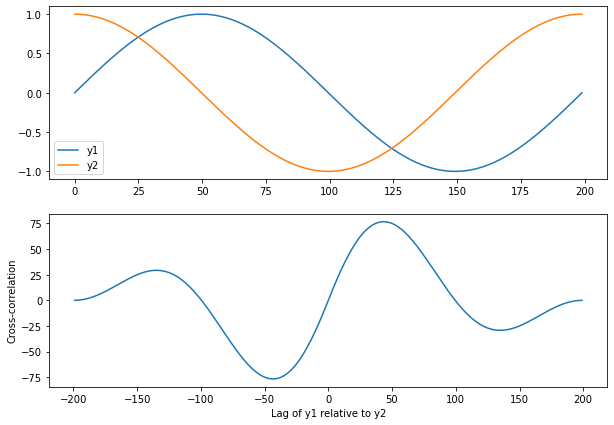

In [3]:
y1 = np.sin(np.linspace(0,np.pi*2,200))
y2 = np.cos(np.linspace(0,np.pi*2,200))

mode = 'full'
signal_corr = signal.correlate(y1, y2, mode=mode)
signal_lags = signal.correlation_lags(y1.size, y2.size, mode=mode)

fig, (ax_signals, ax_corr) = plt.subplots(2, 1, figsize=(10,7))

ax_signals.plot(y1, label='y1')
ax_signals.plot(y2, label='y2')
ax_signals.legend()

ax_corr.plot(signal_lags, signal_corr)

xlim = ax_corr.get_xlim()

ax_corr.set_xlabel('Lag of y1 relative to y2');
ax_corr.set_ylabel('Cross-correlation');

In the plot above, `y1` lags `y2` (alternatively `y2` leads `y1`) which is shown by the peak in correlation at around lag = 50.

In [4]:
False in (signal_lags == np.arange(-199,200))

False

In [5]:
## signal.correlate and np.correlate(mode='full') return the same arrays
## signal.correlate is faster for larger arrays
print('Different values from signal.correlate and np.correlate?')
print(False in (signal.correlate(y1, y2, mode='full') == np.correlate(y1, y2, mode='full')))

Different values from signal.correlate and np.correlate?
False


In [6]:
x = np.array([0,1,2,3,4,5])
skip = 2

shifted = np.array([])

for i in range(skip):
    shifted = np.append(shifted, 0)
    
shifted = np.append(shifted, x[skip:])

np.corrcoef(shifted, x)

array([[1.        , 0.98334342],
       [0.98334342, 1.        ]])

## `plt.xcorr`
It looks like `xcorr(normed=True)*100` $\approx$ `xcorr(normed=False)`

max = 76.72394541018653
argmax = 242
size = 399

max = 0.7672490447748671
argmax = 242
size = 399

(-218.9, 218.9)


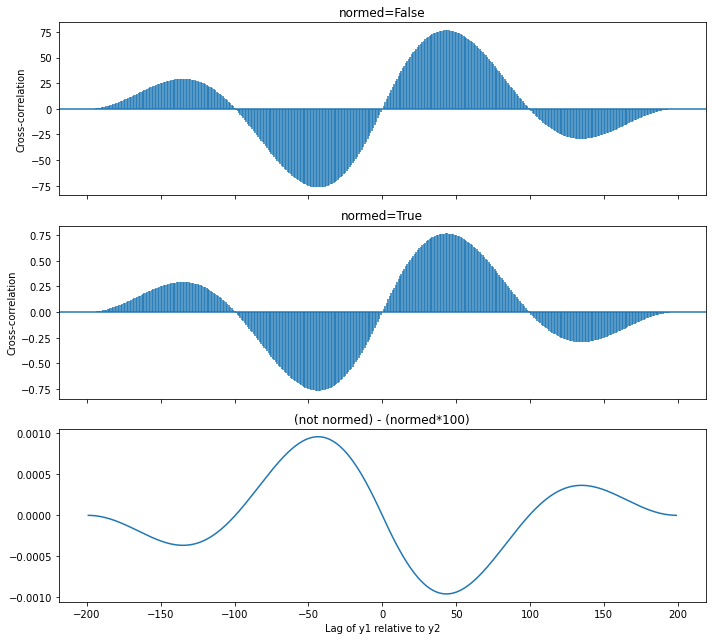

In [9]:
y1 = np.sin(np.linspace(0,np.pi*2,200))
y2 = np.cos(np.linspace(0,np.pi*2,200))

## matplotlib version of xcorr() which uses numpy.correlate(mode='full')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10,9))

maxlags = len(y1)-1

xcorr = ax1.xcorr(y1, y2, maxlags=maxlags, normed=False)
xcorr_normed = ax2.xcorr(y1, y2, maxlags=maxlags, normed=True)
ax3.plot(np.arange(-199,200), xcorr[1] - (xcorr_normed[1]*100))

ax1.set_title('normed=False')
ax2.set_title('normed=True')
ax3.set_title('(not normed) - (normed*100)')

ax1.set_ylabel('Cross-correlation');
ax2.set_ylabel('Cross-correlation');

ax3.set_xlabel('Lag of y1 relative to y2');

fig.tight_layout()

for arr in [xcorr[1], xcorr_normed[1]]:
    print('max = '+str(arr.max()))
    print('argmax = '+str(np.argmax(arr)))
    print('size = '+str(arr.size))
    print()
    
print(ax1.get_xlim())